In [1]:
%run regridding_utils.py
%run  ../diurnal_research/diurnal_config.py
%run  ../diurnal_research/fetch_model_helper.py
import grid_definitions

In [2]:
out_grid_name = 'grid1'

In [3]:
rel_data_dir = '/export/data1/cchristo/'
# get all available model names
rel_cmip6_path= rel_data_dir + 'CMIP6_clouds/clt_3hr_historical/'
rel_cmip5_path = rel_data_dir + 'CMIP5_precip/pr_3hr_historical/'
unique_cmip6_models = get_unique_models(rel_cmip6_path)
unique_cmip5_models = get_unique_models(rel_cmip5_path)

In [4]:
#CMIP5
regrid_weights_dir_cm5 = '/export/data1/cchristo/regridding_weights/CIMP5_to_grid1/'

input_data_dir_cm5 = rel_data_dir  + 'diurnal_analysis_results/CMIP5/' 
output_data_dir_cm5 = rel_data_dir  + 'diurnal_analysis_results/CMIP5_regridded/' 

#CMIP6
regrid_weights_dir_cm6 = '/export/data1/cchristo/regridding_weights/CIMP6_to_grid1/'

input_data_dir_cm6 = rel_data_dir  + 'diurnal_analysis_results/CMIP6_clouds/clt/'
output_data_dir_cm6 = rel_data_dir  + 'diurnal_analysis_results/CMIP6_clt_regridded/' 

#GPM 

regrid_weights_dir_gpm = rel_data_dir  + 'regridding_weights/GPM_to_grid1/'
input_data_dir_gpm = rel_data_dir  + 'diurnal_analysis_results/'
output_data_dir_gpm = rel_data_dir  + 'diurnal_analysis_results/GPM_regridded/' 

#land sea mask
regrid_weights_dir_ls_mask =  rel_data_dir  + 'regridding_weights/GLDASp4_ls_mask_to_grid1/'
input_data_dir_ls_mask = rel_data_dir  + 'land_sea_masks/land_sea_masks_raw/'
output_data_dir_ls_mask = rel_data_dir  + 'land_sea_masks/land_sea_masks_regridded/'

In [5]:
 
ds_out = grid_definitions.grids[out_grid_name]

'/export/data1/cchristo/land_sea_masks/land_sea_masks_regridded/'

In [6]:
def _regrid_generate_fname(ds_in, ds_out,
                          method, label= ''):
    '''Given descriptions of input grid and output grid, generate filename.'''
    res_in_lat = '{val:2.1f}'.format(val = np.median(np.diff(ds_in['lat'].values)))
    res_in_lon = '{val:2.1f}'.format(val = np.median(np.diff(ds_in['lon'].values)))
    res_out_lat = '{val:2.1f}'.format(val = np.median(np.diff(ds_out['lat'].values)))
    res_out_lon = '{val:2.1f}'.format(val = np.median(np.diff(ds_out['lon'].values)))
    
    in_shape_str = str(ds_in['lat'].size) + 'x' + str(ds_in['lon'].size)
    out_shape_str = str(ds_out['lat'].size) + 'x' + str(ds_out['lon'].size)
    
    
    out_string = 'res_' + res_in_lat + 'x' + res_in_lon + '_to_' + res_out_lat + 'x' + res_out_lon + \
        '_size_' + in_shape_str + '_to_' + out_shape_str + '_' + method + '_' + label + '.nc'
    return out_string
    
    
def regrid(ds_in, 
           ds_out,
           method = 'bilinear', 
           label = '',
           reuse_weights = True,
           regrid_weights_dir = None,
           regridder = None):
    '''Regrid input dataset to output dataset. 
    If regridding weights already exist in regrid_weights_dir, use them. 
    Otherwise create new ones.
    Note: only works for rectilinear grids!  Input lat/lon coords should be 1D.
    
    Args
    ---------
        ds_in - ds.DataSet
            xarray dataset that contains coordinates ('lon', 'lat')
            Input lat/lon coords should be 1D
        reuse_weights - bool 
            If weights already exist, use them to regrid. If not, create, save, then use.
        regrid_weights_dir
            path to search for weight. Don't forget trailing backslash!
        
    
    '''
    if (ds_in['lat'].ndim > 1) | (ds_in['lon'].ndim > 1):
        raise(Exception('Input lat/lons are not 1d!'))
    
    if (ds_out['lat'].ndim > 1) | (ds_out['lon'].ndim > 1):
        raise(Exception('Output lat/lons are not 1d!'))
    
    out_weights_filepath = regrid_weights_dir + \
                            _regrid_generate_fname(ds_in, ds_out, method = method, label = label)
#     print(out_weights_filepath)
    if reuse_weights:
        if not regrid_weights_dir:
            raise(Exception('regrid_weights_dir not specified!'))
        # if weight file exists, use it
        if os.path.exists(out_weights_filepath):
            regridder = xe.Regridder(ds_in, ds_out, 
                         method = method, 
                         reuse_weights = True, 
                         filename = out_weights_filepath)
            ds_regridded = regridder(ds_in)
            return ds_regridded
        # if weight file doesn't exist, create it
        else:
            print('Weight file does not exist. Computing...')
#             rel_weight_path = os.path.dirname(out_weights_filepath)
            if not os.path.exists(regrid_weights_dir):
                os.makedirs(regrid_weights_dir)
            
            regridder = xe.Regridder(ds_in, ds_out, 
                         method = method, 
                         filename = out_weights_filepath)
            
            ds_regridded = regridder(ds_in)
            return ds_regridded
        
#     if (not reuse_weights) & (not regridder):
#         regridder = xe.Regridder(ds_in, ds_out, 
#                              method = method, 
#                              reuse_weights = False)

In [109]:
model_name = 'GFDL-CM3'

ds_in = xr.open_dataset(input_data_dir_cm5 + 'GFDL-CM3' + '/' + '1985-01_2006-01_precip.nc')


res = regrid(ds_in, 
       ds_out,
       method = 'nearest_s2d',
       label = model_name + '_to_' + 'grid1',
       regrid_weights_dir = regrid_weights_dir)

/export/data1/cchristo/regridding_weights/CIMP5_to_grid1/res_2.0x2.5_to_0.5x0.5_size_60x144_to_240x720_nearest_s2d_GFDL-CM3_to_grid1.nc
Weight file does not exist. Computing...
Create weight file: /export/data1/cchristo/regridding_weights/CIMP5_to_grid1/res_2.0x2.5_to_0.5x0.5_size_60x144_to_240x720_nearest_s2d_GFDL-CM3_to_grid1.nc
using dimensions ('lat', 'lon') from data variable mu_season as the horizontal dimensions for this dataset.


In [29]:
ds_in['mu_season'].isel(season = 0).plot.imshow(cmap =  plt.get_cmap('gist_ncar'))

NameError: name 'ds_in' is not defined

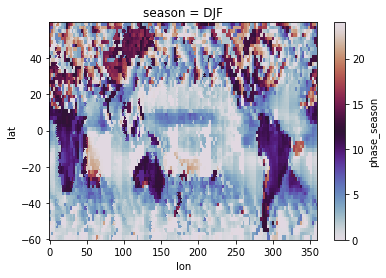

In [113]:
res['phase_season'].isel(season = 0).plot.imshow(cmap = plt.get_cmap('twilight'))

In [130]:
output_data_dir_cm5

'/export/data1/cchristo/diurnal_analysis_results/CMIP5_regridded/'

In [7]:
# fname = '1985-01_2006-01_precip_diurnal_means.nc'
# out_grid_name = 'grid1'

def regrid_cmip_models_in_dir(model_list, 
                              ds_out, 
                              input_data_dir_rel_path, 
                              output_data_dir_rel_path,
                              regrid_weights_dir, 
                              fname = '1985-01_2006-01_precip.nc',
                              method = 'nearest_s2d',
                              out_grid_name = 'grid1',
                              overwrite = True):
    '''Regrids netCDFs with name fname in subdirectories (model names in model_list)
    Args
    -----
    model_list - list of str
        list containing cmip model names
    out_grid_name - str
        used to label subdirs, files in output
    
    '''
    for model_ii in model_list:
        in_ds_path = input_data_dir_rel_path + model_ii + '/' + fname 
        try:
            ds_in = xr.open_dataset(in_ds_path)
            ds_regridded = regrid(ds_in, 
                                  ds_out,
                                  method = method,
                                  label = model_ii + '_to_' + 'grid1',
                                  regrid_weights_dir = regrid_weights_dir)
            out_ds_rel_path = output_data_dir_rel_path + out_grid_name + '/' + model_ii + '/'
            if not os.path.exists(out_ds_rel_path):
                os.makedirs(out_ds_rel_path)
            ds_regridded.to_netcdf(out_ds_rel_path + out_grid_name  + '_' + fname)

        except Exception as e:
            print('Could not regrid ' + model_ii + ' : ' + str(e))

# Regrid Diurnal Analysis Results

### Regrid CMIP5 models

In [8]:
regrid_cmip_models_in_dir(model_list = unique_cmip5_models,
                          ds_out = ds_out,
                          method = 'nearest_s2d',
                          regrid_weights_dir = regrid_weights_dir_cm5,
                          input_data_dir_rel_path = input_data_dir_cm5, 
                          output_data_dir_rel_path = output_data_dir_cm5,
                          out_grid_name = out_grid_name)

Reuse existing file: /export/data1/cchristo/regridding_weights/CIMP5_to_grid1/res_2.8x2.8_to_0.5x0.5_size_44x128_to_240x720_nearest_s2d_FGOALS-g2_to_grid1.nc
using dimensions ('lat', 'lon') from data variable mu_season as the horizontal dimensions for this dataset.
Reuse existing file: /export/data1/cchristo/regridding_weights/CIMP5_to_grid1/res_2.0x2.5_to_0.5x0.5_size_60x144_to_240x720_nearest_s2d_GFDL-CM3_to_grid1.nc
using dimensions ('lat', 'lon') from data variable mu_season as the horizontal dimensions for this dataset.
Reuse existing file: /export/data1/cchristo/regridding_weights/CIMP5_to_grid1/res_1.7x2.8_to_0.5x0.5_size_72x128_to_240x720_nearest_s2d_FGOALS-s2_to_grid1.nc
using dimensions ('lat', 'lon') from data variable mu_season as the horizontal dimensions for this dataset.
Reuse existing file: /export/data1/cchristo/regridding_weights/CIMP5_to_grid1/res_1.1x1.1_to_0.5x0.5_size_108x320_to_240x720_nearest_s2d_MRI-CGCM3_to_grid1.nc
using dimensions ('lat', 'lon') from data va

In [21]:
output_data_dir_cm6

'/export/data1/cchristo/diurnal_analysis_results/CMIP6_clt_regridded/'

### Regrid CMIP6 Models

In [27]:
regrid_cmip_models_in_dir(model_list = unique_cmip6_models,
                          ds_out = ds_out,
                          method = 'nearest_s2d',
                          fname = '1985-01_2006-01_clt.nc',
                          regrid_weights_dir = regrid_weights_dir_cm6,
                          input_data_dir_rel_path = input_data_dir_cm6, 
                          output_data_dir_rel_path = output_data_dir_cm6,
                          out_grid_name = out_grid_name)

Could not regrid CESM2 : [Errno 2] No such file or directory: b'/export/data1/cchristo/diurnal_analysis_results/CMIP6_clouds/clt/CESM2/1985-01_2006-01_clt.nc'
Reuse existing file: /export/data1/cchristo/regridding_weights/CIMP6_to_grid1/res_0.9x1.2_to_0.5x0.5_size_128x288_to_240x720_nearest_s2d_SAM0-UNICON_to_grid1.nc
using dimensions ('lat', 'lon') from data variable mu_season as the horizontal dimensions for this dataset.
Weight file does not exist. Computing...
Create weight file: /export/data1/cchristo/regridding_weights/CIMP6_to_grid1/res_1.0x1.2_to_0.5x0.5_size_120x288_to_240x720_nearest_s2d_FGOALS-f3-L_to_grid1.nc
using dimensions ('lat', 'lon') from data variable mu_season as the horizontal dimensions for this dataset.
Reuse existing file: /export/data1/cchristo/regridding_weights/CIMP6_to_grid1/res_1.1x1.1_to_0.5x0.5_size_108x320_to_240x720_nearest_s2d_BCC-CSM2-MR_to_grid1.nc
using dimensions ('lat', 'lon') from data variable mu_season as the horizontal dimensions for this dat

### Regrid GPM

In [10]:
regrid_cmip_models_in_dir(model_list = ['GPM',],
                          ds_out = ds_out,
                          method = 'nearest_s2d',
                          fname = '2000-06_2010-06_precip.nc',
                          regrid_weights_dir = regrid_weights_dir_gpm,
                          input_data_dir_rel_path = input_data_dir_gpm, 
                          output_data_dir_rel_path = output_data_dir_gpm,
                          out_grid_name = out_grid_name)

Weight file does not exist. Computing...
Create weight file: /export/data1/cchristo/regridding_weights/GPM_to_grid1/res_1.0x1.2_to_0.5x0.5_size_120x288_to_240x720_nearest_s2d_GPM_to_grid1.nc
using dimensions ('lat', 'lon') from data variable mu_season as the horizontal dimensions for this dataset.


### Regrid Land/Sea Mask

In [126]:

ds_land_sea = xr.open_dataset(input_data_dir_land_sea_mask + 'GLDASp4_landmask_1d.nc4')
ds_in = ds_land_sea.copy().transpose('time','lat','lon', 'bnds')
ds_in = ds_in.drop(['time','time_bnds'])
#  regridder(ds_in['GLDAS_mask'].transpose('time','lat','lon'))
land_sea_regridded = regrid(ds_in, 
                            ds_out,
                            method = 'nearest_s2d',
                            label = 'GLDASp4' + '_to_' + 'grid1',
                            regrid_weights_dir = regrid_weights_dir_ls_mask)
# get rid of time dim for consistency before saving
land_sea_regridded = land_sea_regridded['GLDAS_mask'].isel(time = 0)

land_sea_regridded.to_netcdf(output_data_dir_ls_mask + out_grid_name + '/' + out_grid_name + '_GLDASp4_landmask_1d.nc')

Reuse existing file: /export/data1/cchristo/regridding_weights/GLDASp4_ls_mask_to_grid1/res_1.0x1.0_to_0.5x0.5_size_150x360_to_240x720_nearest_s2d_GLDASp4_to_grid1.nc
using dimensions ('lat', 'lon') from data variable GLDAS_mask as the horizontal dimensions for this dataset.


In [123]:
# ds_in['GLDAS_mask'].drop(['time'])
output_data_dir_ls_mask

'/export/data1/cchristo/land_sea_masks/land_sea_masks_regridded/'

In [108]:

ds_in['GLDAS_mask'] = ds_in['GLDAS_mask'].drop(['time'])

ValueError: One or more of the specified variables cannot be found in this dataset

In [ ]:
# this can be useful later, but not now
def regrid_netcdf_file_list(file_paths, ds_out, output_regridded_dir):
    
    for file_i in file_paths:
        ds_regridded = regrid(ds_in, 
                              ds_out,
                              method = 'nearest_s2d',
                              label = model_name + '_to_' + 'grid1',
                              regrid_weights_dir = regrid_weights_dir)
        

# def regrid_netcdfs_in_dir(input_dir, output_regridded_dir):
#     '''Given path to directory with netcdfs (input_dir), regrid netcdfs (using saved weights if possible)
#     and output regridded netcdfs to output_regridded_dir'''